In [1]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 

import matplotlib.pyplot as plt 

In [2]:
filesTrainCOV= glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*')
filesTrainNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*')
filesTestCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*')
filesTestNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*')
filesValCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*')
filesValNO=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*')

In [3]:
COVID_train = [fn for fn in filesTrainCOV if 'covid' in fn] 
HEALTHY_train = [fn for fn in filesTrainNO if 'COVID' in fn] 
 
COVID_val = [fn for fn in filesValCOV if 'covid' in fn] 
HEALTHY_val = [fn for fn in filesValNO if 'COVID' in fn] 

COVID_test = [fn for fn in filesTestCOV if 'covid' in fn] 
HEALTHY_test = [fn for fn in filesTestNO if 'COVID' in fn]  
len(COVID_train), len(COVID_val), len(COVID_test) ,len(HEALTHY_train), len(HEALTHY_val), len(HEALTHY_test)


(7658, 1903, 2395, 7208, 1802, 2253)

In [4]:
train_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train' 
val_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid' 
test_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
for fn in test_files: 
    shutil.copy(fn, test_dir) 
 

In [5]:
test_files.shape

(4648,)

In [6]:
IMG_DIM = (150, 150) 
 
train_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (14866, 150, 150, 3) Validation dataset shape: (3705, 150, 150, 3)


In [7]:
train_labels=train_labels[:10000]
validation_labels=validation_labels[:2000]

In [8]:
train_imgs=train_imgs[:10000]
validation_imgs=validation_imgs[:2000]

(150, 150, 3)


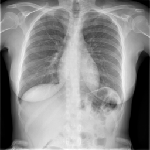

In [9]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [10]:
for i in range(10000):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [11]:
train_labels[1500:3000]

['covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',


In [12]:
batch_size = 30 
num_classes = 2 
epochs = 30 
input_shape = (150, 150, 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3,  
                                   rotation_range=50, 
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,   
                                   shear_range=0.2,  
                                   horizontal_flip=True,   
                                   fill_mode='nearest') 
 
val_datagen = ImageDataGenerator(rescale=1./255) 

In [14]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 
 
vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_23460\1885812186.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x0000025B845CA2E0>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000258ECF8EF70>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000258ECF8E0A0>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025B84699490>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x00000258CD2137F0>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025B846EC580>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025B846EC940>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025B846ECE20>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025B8477B910>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025B847772B0>,block3_conv3,False


In [16]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 4s 4s/step
(1, 4, 4, 512)


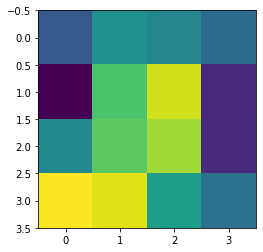

In [17]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [18]:
import tensorflow as tf

In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [20]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_vgg = get_bottleneck_features(vgg_model, 
                                             train_imgs_scaled) 
validation_features_vgg = get_bottleneck_features(vgg_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape) 

Train Bottleneck Features: (10000, 8192) 	Validation Bottleneck Features: (2000, 8192)


In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

In [22]:
model = BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
)

In [23]:
history = model.fit(train_features_vgg, y=train_labels_enc)

In [24]:
scores = cross_val_score(BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
), train_features_vgg ,train_labels_enc, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores.mean()

0.87 accuracy with a standard deviation of 0.01


0.8712

In [25]:
f1_score(validation_labels_enc,history.predict(validation_features_vgg))

0.42105263157894735

In [26]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5)

In [27]:
classifier.fit(train_features_vgg, y=train_labels_enc)

RandomForestClassifier(n_estimators=5)

In [28]:
ypredd=classifier.predict(validation_features_vgg)

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(validation_labels_enc, ypredd)
print(cm)
accuracy_score(validation_labels_enc, ypredd)

[[1806   97]
 [  39   58]]


0.932